In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_pi = 0.13957
m_K = 0.49368
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

mD* - mD0 = 0.14543


In [25]:
label_dic = {'Data' : 'Data',
             'mu'   : 'B#rightarrow D*#mu#nu',
             'tau'  : 'B#rightarrow D*#tau#nu',
             'Hc'   : 'B#rightarrow D*H_{c}',
             'Dstst': 'B#rightarrow D**#mu#nu'
            }

In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [6]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

# Load data

In [22]:
loc = '../data/cmsRD/'
loc += 'ParkingBPH1/'
loc += 'Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_191126_CAND.root'

tData = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tData.Add(floc)

print 'N evts: {:.0f}'.format(tData.GetEntries())

N evts: 533512


In [7]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tMu = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tMu.Add(floc)

print 'N evts: {:.0f}'.format(tMu.GetEntries())

N evts: 218709


Error in <TChain::LoadTree>: Cannot find tree with name outA/Tevts in file ../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_26.root
Error in <TChain::LoadTree>: Cannot find tree with name outA/Tevts in file ../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_51.root


In [8]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tTau = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tTau.Add(floc)

print 'N evts: {:.0f}'.format(tTau.GetEntries())

N evts: 48330


In [9]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tDstst = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tDstst.Add(floc)

print 'N evts: {:.0f}'.format(tDstst.GetEntries())

N evts: 85378


# Cuts declaration

In [10]:
cut_general = [
    'n_B == 1',
    'trgMu_pt > 12.1',
    'trgMu_sigdxy > 7'
]

# $D_0$ reconstruction

In [11]:
cut_piK = [
####----- Trigger-like cuts -----#
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'K_eta > -2.5',
'pi_eta > -2.5',
'K_eta < 2.5',
'pi_eta < 2.5',
    
# 'cosT_Jpsi_PV > 0.95',
# 'sigdxy_K_PV > 2',
# 'mup_dxy < 2',
]

In [12]:
cut_piK += ['mass_D0pis < mass_piK + 0.16', 'abs(mass_piK - 1.86) < 0.04']
cut_piK = list(dict.fromkeys(cut_piK))
cut_piK

['pval_piK > 0.1',
 'K_pt > 0.8',
 'pi_eta < 2.5',
 'K_eta < 2.5',
 'abs(mass_piK - 1.86) < 0.04',
 'pi_eta > -2.5',
 'K_eta > -2.5',
 'mass_D0pis < mass_piK + 0.16',
 'pi_pt > 0.8']

# $D^*$ Recostruction

In [13]:
cut_D0pis = [
'pis_pt > 0.5'
'pis_refitD0pismu_pt > 0.5',
'sigdxy_pis_PV > 2',
'pval_D0pis > 0.1',
'cos_D0pismu_PV > 0.99'
]

In [14]:
cut_str = ' && '.join(cut_general + cut_piK + cut_D0pis)
print cut_str

n_B == 1 && trgMu_pt > 13 && trgMu_sigdxy > 6.5 && pval_piK > 0.1 && K_pt > 0.8 && pi_eta < 2.5 && K_eta < 2.5 && abs(mass_piK - 1.86) < 0.04 && pi_eta > -2.5 && K_eta > -2.5 && mass_D0pis < mass_piK + 0.16 && pi_pt > 0.8 && pis_refitD0pismu_pt > 0.5 && sigdxy_pis_PV > 2 && pval_D0pis > 0.1


In [15]:
cut_D0pis += ['abs(mass_D0pis - 2.01) < 0.03']
cut_D0pis = list(dict.fromkeys(cut_D0pis))
print cut_D0pis

['pis_refitD0pismu_pt > 0.5', 'pval_D0pis > 0.1', 'abs(mass_D0pis - 2.01) < 0.03', 'sigdxy_pis_PV > 2']


# Full analysis

In [29]:
cut_B = [
    'pval_D0pismu > 0.1',
    'mass_D0pismu < 7.0'
]
print cut_B

cut_str = ' && '.join(cut_general + cut_piK + cut_D0pis + cut_B)

['pval_D0pismu > 0.1', 'mass_D0pismu < 7.0']


# Study on the additional tracks

Mu: 4040/40783 = 9.9 %
Tau: 514/6249 = 8.2 %
Dstst: 11319/13938 = 81.2 %


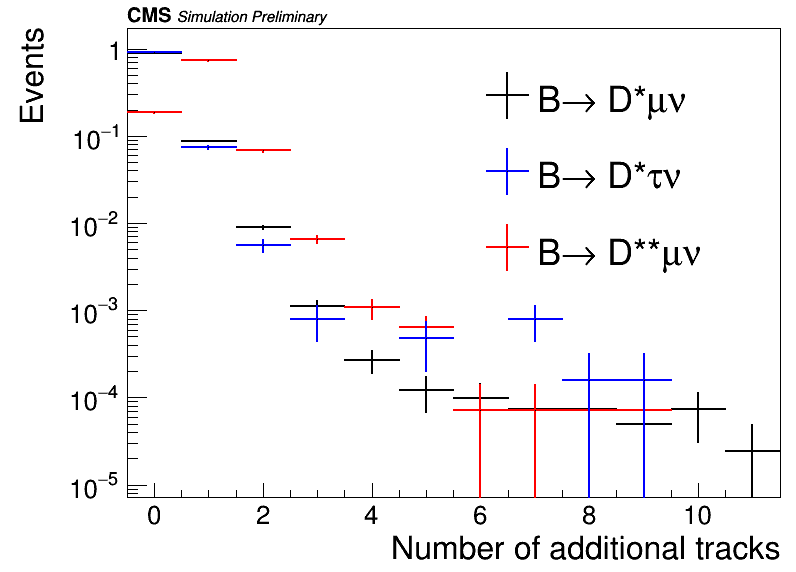

In [17]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Number of additional tracks', 'Events'],
                binning=[12, -0.5, 11.5]
               )
tMu.Project('h', 'nTksAdd', cut_str)
h.Sumw2()
h.Scale(1./h.Integral())
N = tMu.GetEntries(cut_str)
n = tMu.GetEntries(cut_str + ' && nTksAdd >= 1')
print 'Mu: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', 'nTksAdd', cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)
N = tTau.GetEntries(cut_str)
n = tTau.GetEntries(cut_str + ' && nTksAdd >= 1')
print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', 'nTksAdd', cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)
N = tDstst.GetEntries(cut_str)
n = tDstst.GetEntries(cut_str + ' && nTksAdd >= 1')
print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

leg = rt.TLegend(0.6, 0.5, 0.9, 0.9)
leg.AddEntry(h, label_dic['mu'], 'lep')
leg.AddEntry(h3, label_dic['tau'], 'lep')
leg.AddEntry(h2, label_dic['Dstst'], 'lep')
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.SetLogy()
leg.Draw()
c.Draw()

Dstst: 8414/13938 = 60.4 %
Tau: 67/6249 = 1.1 %


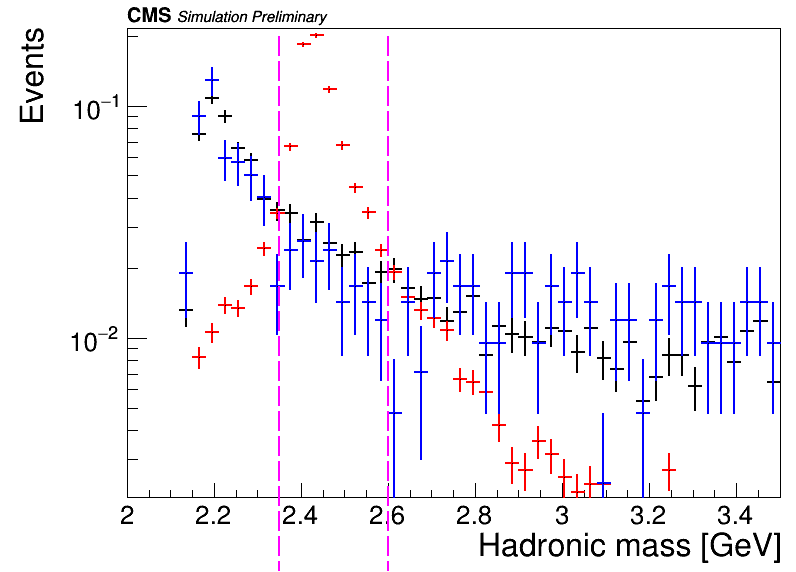

In [18]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Hadronic mass [GeV]', 'Events'],
                binning=[50, 2, 3.5]
               )
tMu.Project('h', 'tksAdd_massHad', cut_str)
h.Sumw2()
h.Scale(1./h.Integral())

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', 'tksAdd_massHad', cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)
N = tDstst.GetEntries(cut_str)
n = tDstst.GetEntries(cut_str + ' && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6')
print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)  

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', 'tksAdd_massHad', cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)
N = tTau.GetEntries(cut_str)
n = tTau.GetEntries(cut_str + ' && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6')
print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)  

c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.SetLogy()
cl.DrawLine(2.35, 1e-3, 2.35, 0.2)
cl.DrawLine(2.6, 1e-3, 2.6, 0.2)
c.Draw()

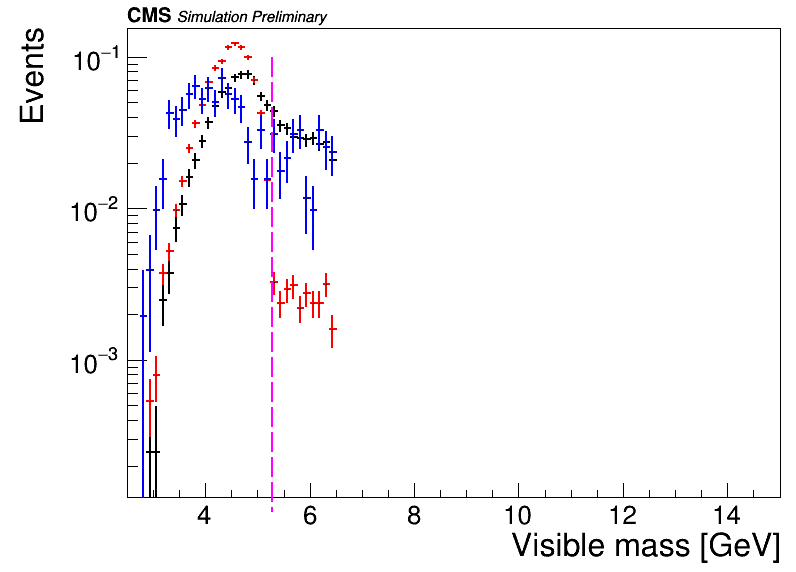

In [23]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Visible mass [GeV]', 'Events'],
                binning=[100, 2.5, 15]
               )
tMu.Project('h', 'tksAdd_massVis', cut_str)
h.Sumw2()
h.Scale(1./h.Integral())

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', 'tksAdd_massVis', cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', 'tksAdd_massVis', cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)
   
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.SetLogy()
cl.DrawLine(m_B0, 1e-4, m_B0, 1e-1)
c.Draw()

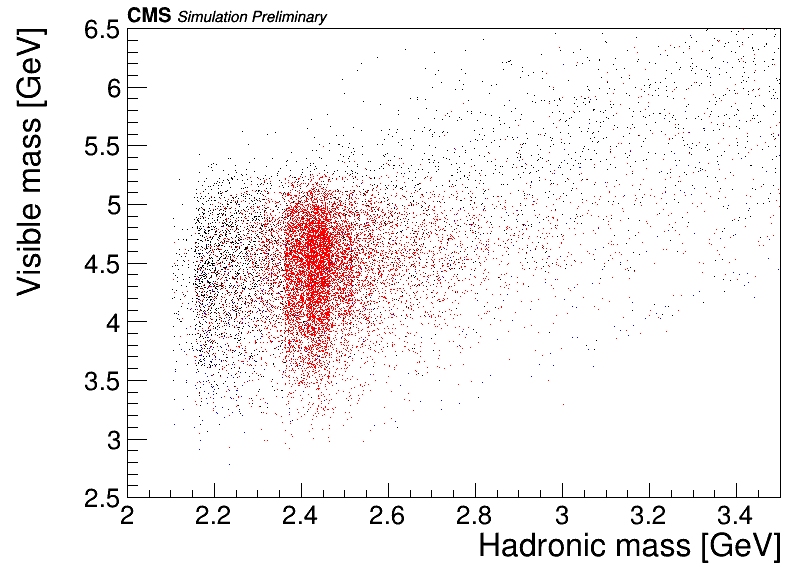

In [20]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['Hadronic mass [GeV]', 'Visible mass [GeV]', 'Events'],
                binning=[np.linspace(2, 3.5, 30), np.linspace(2.5, 6.5, 30)]
               )
tMu.Project('h', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h.Sumw2()

h2 = create_TH2D(np.zeros((2,2)), name='h2', binning=h.binning)
tDstst.Project('h2', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h2.Sumw2()
h2.SetMarkerColor(rt.kRed)

h3 = create_TH2D(np.zeros((2,2)), name='h3', binning=h.binning)
tTau.Project('h3', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h3.Sumw2()
h3.SetMarkerColor(rt.kBlue)
                         
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
# cl.DrawLine(1.76, 1.76+0.16, 1.91, 1.91+0.16)
# c.SetLogy()
c.Draw()

Mu: 2964/40783 = 7.3 %
Tau: 409/6249 = 6.5 %
Dstst: 11258/13938 = 80.8 %
Data: 19390/119866 = 16.2 %


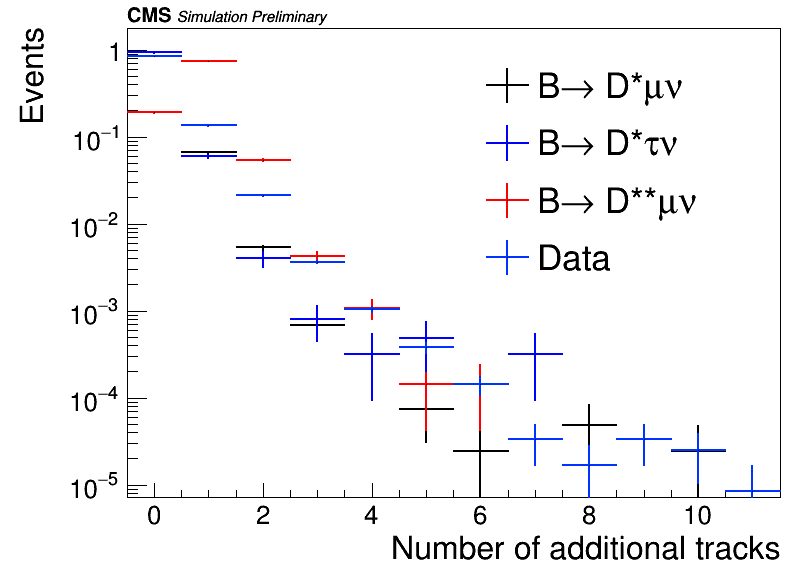

In [28]:
var = 'Sum$(tksAdd_massVis < {})'.format(m_B0)
# var = 'Sum$(tksAdd_massVis < {})'.format(6.5)
# var = 'Sum$(tksAdd_massVis < {} && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6)'.format(m_B0)

h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Number of additional tracks', 'Events'],
                binning=[12, -0.5, 11.5]
               )
tMu.Project('h', var, cut_str)
h.Sumw2()
h.Scale(1./h.Integral())
N = tMu.GetEntries(cut_str)
n = tMu.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Mu: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', var, cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)
N = tTau.GetEntries(cut_str)
n = tTau.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', var, cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)
N = tDstst.GetEntries(cut_str)
n = tDstst.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)


h4 = create_TH1D(np.zeros(0), name='h4', binning=h.binning)
tData.Project('h4', var, cut_str)
h4.Sumw2()
h4.Scale(1./h4.Integral())
h4.SetLineColor(rt.kAzure)
N = tData.GetEntries(cut_str)
n = tData.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Data: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

leg = rt.TLegend(0.6, 0.5, 0.9, 0.9)
leg.AddEntry(h, label_dic['mu'], 'lep')
leg.AddEntry(h3, label_dic['tau'], 'lep')
leg.AddEntry(h2, label_dic['Dstst'], 'lep')
leg.AddEntry(h4, label_dic['Data'], 'lep')
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3, h4], 'same')
c.SetLogy()
leg.Draw()
c.Draw()